In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from scipy.stats.stats import pearsonr
from sklearn.metrics import matthews_corrcoef

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# mxnet1.6.0 env
import cv2
import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../resuneta/nn/loss')
sys.path.append('../../resuneta/models')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from resunet_d6_causal_mtskcolor_ddist import *
from resunet_d7_causal_mtskcolor_ddist import *
from datasets import *

# Load model

In [ ]:
# ==================== USER SETTINGS ==================== #
# models evaluated:
# 'resunet-d6_janAprOct_nfilter-16_bs-8_lr-0.001'

n_filters = 16
n_classes = 1
hsv_channels = 3
model_name = 'resunet-d6_october_class-subset_nfilter-16_bs-8_lr-0.001'

file_name = '../experiments/france/sherrie10k/{}/model.params'.format(model_name)
model = ResUNet_d6(_nfilters_init=n_filters, 
                   _NClasses=n_classes,
                   hsv_outchannels=hsv_channels)
gpu = 3
model.load_parameters(file_name, ctx=mx.gpu(3))
# ======================================================= #

# Run validation images through model

In [20]:
# ==================== USER SETTINGS ==================== #
image_directories = '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/2019_10/'
label_directory = '../data/planet/france/sherrie10k/extent_labels/'
batch_size = 8

splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_10x10.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
save_dir = '../results/france/sherrie10k/{}'.format(model_name)

# image_directories = '../data/planet/france/hanBurak2k/april_256x256/'
#                      '../data/planet/france/hanBurak2k/january_256x256/'
#                      '../data/planet/france/hanBurak2k/october_256x256/'
# label_directory = '../data/planet/france/hanBurak2k/labels_256x256/'
# splits_df = pd.read_csv('../data/splits/hanAndBurak_planetImagery_splits.csv')
# save_dir = '../results/france/hanAndBurak/{}'.format(model_name)
# ======================================================= #

train_names = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_names = splits_df[splits_df['fold'] == 'val']['image_id'].values

# setting fold = 'val' means no data augmentation
train_dataset = PlanetDatasetWithClasses(image_directories, label_directory, classes=list(np.arange(1,28, dtype=np.uint8)),
                                         image_names=train_names, fold='val', image_suffix='_2019_10.tif')
val_dataset = PlanetDatasetWithClasses(image_directories, label_directory, classes=list(np.arange(1,28, dtype=np.uint8)),
                                       image_names=val_names, fold='val', image_suffix='_2019_10.tif')
# train_dataset = PlanetMultitemp(image_directories, label_directory, image_names=train_names)
# val_dataset = PlanetMultitemp(image_directories, label_directory, image_names=val_names)

train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

In [26]:
# Save all predictions for training and validation sets
all_dataloaders = [train_dataloader, val_dataloader]
all_names = [train_names, val_names]

# initialize metrics
true_counts = []
pred_counts = []
true_sizes = []
pred_sizes = []
mccs = []

# validation set
for c, current_dataloader in enumerate(all_dataloaders):
    if c == 0:
        print('train')
    else:
        print('val')
    for batch_i, (img, extent, boundary, distance, hsv) in enumerate(current_dataloader): # val_dataloader

        img = img.as_in_context(mx.gpu(gpu))
        extent = extent.as_in_context(mx.gpu(gpu))
        boundary = boundary.as_in_context(mx.gpu(gpu))
        distance = distance.as_in_context(mx.gpu(gpu))
        hsv = hsv.as_in_context(mx.gpu(gpu))

        logits, bound, dist, convc = model(img)

        extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
        boundary_predicted_classes = mx.nd.ceil(bound[:,[0],:,:] - 0.5)

        # Difference out borders
        diff = extent_predicted_classes - boundary_predicted_classes

        # Symmetric difference
    #     diff = np.logical_xor(extent_predicted_classes.asnumpy(), boundary_predicted_classes.asnumpy())

        for i, diffed in enumerate(diff):
            diffed = np.maximum(diffed.asnumpy(), 0)
            pred_count, instanceSeg_pred, stats_pred, centroids_pred = cv2.connectedComponentsWithStats(
                diffed[0].astype(np.uint8), connectivity=8)
            true_count, instanceSeg, stats, centroids = cv2.connectedComponentsWithStats(
                extent[i].asnumpy()[0].astype(np.uint8), connectivity=8)
            true_counts.append(true_count)
            pred_counts.append(pred_count)
            true_sizes = true_sizes + list(stats[:,-1][1:])
            pred_sizes = pred_sizes + list(stats_pred[:,-1][1:])

            # Compute MCC
            y_true = extent[i].asnumpy()[0].astype(np.int8).flatten()
            y_true[y_true == 0] = -1
            y_pred = extent_predicted_classes[i].asnumpy()[0].astype(np.int8).flatten()
            y_pred[y_pred == 0] = -1
            mcc = matthews_corrcoef(y_true, y_pred)
            mccs.append(mcc)

            # save predictions
#             current_names = all_names[c]
#             image_id = current_names[batch_i * batch_size + i]
#             np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
#             np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

#             print(val_names[batch_i * batch_size + i], mcc)
#             fig, ax = plt.subplots(1,5, figsize=(18,4))
#             ax[0].imshow(np.moveaxis(img.asnumpy()[i][:3], 0, -1) / 255.)
#             ax[1].imshow(np.moveaxis(img.asnumpy()[i][3:6], 0, -1) / 255.)
#             ax[2].imshow(np.moveaxis(img.asnumpy()[i][-3:], 0, -1) / 255.)
#             ax[-2].imshow(instanceSeg)
#             ax[-1].imshow(instanceSeg_pred)
#             plt.show()
#         break

train
val


In [27]:
np.mean(mccs)

0.31058915917045204

In [30]:
mcc_df = pd.DataFrame({'image_id': list(train_names) + list(val_names),
              'MCC': mccs})
mcc_df = mcc_df.merge(splits_df, on='image_id', how='inner')

In [31]:
mcc_df

image_id       MCC        lat       lon   fold
0       00002  0.000000  46.215638  4.184958  train
1       00005  0.460206  49.262867 -1.543390  train
2       00006  0.705132  48.612362  4.856614  train
3       00007  0.457534  46.361416  3.268474  train
4       00008  0.000000  44.883682  6.275156  train
...       ...       ...        ...       ...    ...
8308    09969  0.467922  45.860011  0.406684    val
8309    09972  0.369007  46.257615  5.336083    val
8310    09976  0.735529  44.554267  0.135020    val
8311    09988  0.559563  49.269957  4.219056    val
8312    09989  0.000000  44.855703 -0.680789    val

[8313 rows x 5 columns]

# Sherrie 10k samples

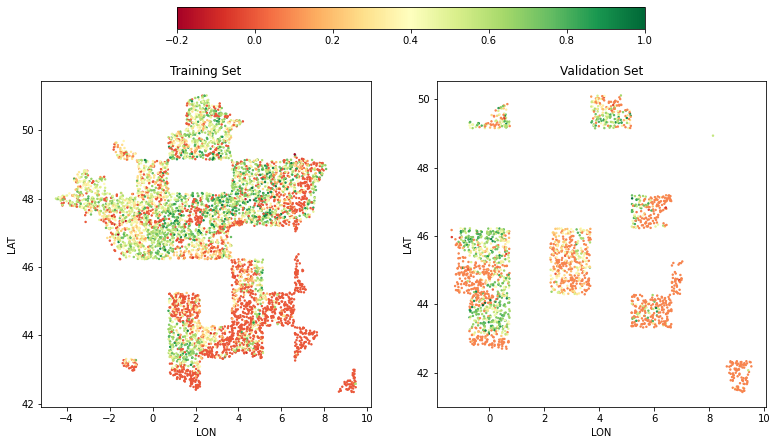

In [32]:
# splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_10x10.csv')
# splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
# splits_df['MCC'] = mccs
val_df = mcc_df[mcc_df['fold'] == 'val']
train_df = mcc_df[mcc_df['fold'] == 'train']

fig, ax = plt.subplots(1,2, figsize=(13,6))
im = ax[0].scatter(train_df['lon'], train_df['lat'], c=train_df['MCC'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df['lon'], val_df['lat'], c=val_df['MCC'], s=2, cmap='RdYlGn')

for i in range(2):
    ax[i].set_xlabel('LON')
    ax[i].set_ylabel('LAT')
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')

cax = fig.add_axes([0.27, 1, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

# Han and Burak's samples

## Correlation between actual and predicted number of fields per image

In [ ]:
r = pearsonr(true_counts, pred_counts)
r2 = r[0]**2

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(pred_counts, true_counts, s=2, alpha=0.5)
plt.plot([0, 200], [0, 200], '-', color='black')
plt.title('True vs. Predicted Field Counts per Image\nConnectivity=8')
plt.ylabel('True Fields per Image')
plt.xlabel('Predicted Fields per Image')
plt.annotate("$r^2 = ${:0.2f}".format(r2), (150, 75))
plt.show()

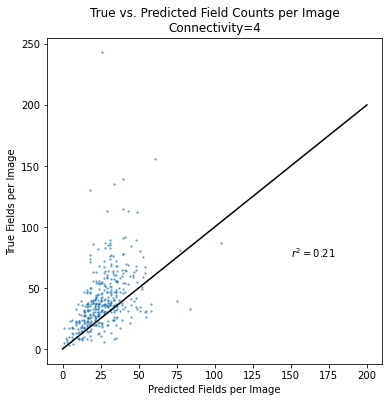

In [59]:
r = pearsonr(true_counts, pred_counts)
r2 = r[0]**2

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(pred_counts, true_counts, s=2, alpha=0.5)
plt.plot([0, 200], [0, 200], '-', color='black')
plt.title('True vs. Predicted Field Counts per Image\nConnectivity=4')
plt.ylabel('True Fields per Image')
plt.xlabel('Predicted Fields per Image')
plt.annotate("$r^2 = ${:0.2f}".format(r2), (150, 75))
plt.show()

## Difference out border predictions

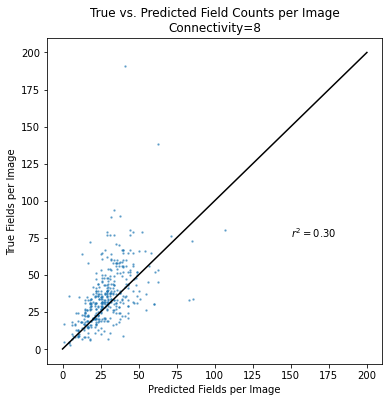

In [69]:
# after differencing out the border prediction
r = pearsonr(true_counts, pred_counts)
r2 = r[0]**2

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(pred_counts, true_counts, s=2, alpha=0.5)
plt.plot([0, 200], [0, 200], '-', color='black')
plt.title('True vs. Predicted Field Counts per Image\nConnectivity=8')
plt.ylabel('True Fields per Image')
plt.xlabel('Predicted Fields per Image')
plt.annotate("$r^2 = ${:0.2f}".format(r2), (150, 75))
plt.show()

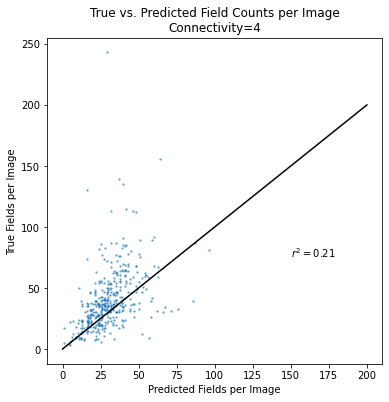

In [67]:
# after differencing out the border prediction
r = pearsonr(true_counts, pred_counts)
r2 = r[0]**2

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(pred_counts, true_counts, s=2, alpha=0.5)
plt.plot([0, 200], [0, 200], '-', color='black')
plt.title('True vs. Predicted Field Counts per Image\nConnectivity=4')
plt.ylabel('True Fields per Image')
plt.xlabel('Predicted Fields per Image')
plt.annotate("$r^2 = ${:0.2f}".format(r2), (150, 75))
plt.show()

### Distribution of field sizes

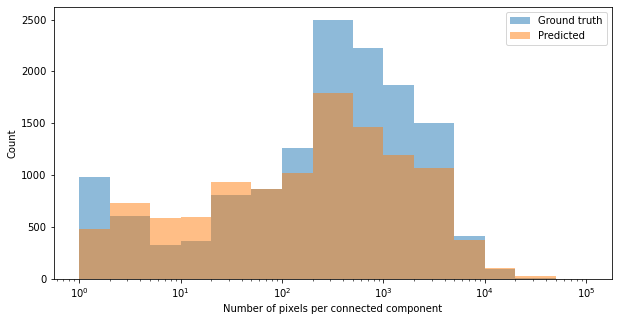

In [114]:
fig, ax = plt.subplots(figsize=(10,5))

bins = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,1e5]
plt.hist(true_sizes, bins=bins, alpha=0.5)
plt.hist(pred_sizes, bins=bins, alpha=0.5)
plt.xscale('log')
plt.xlabel('Number of pixels per connected component')
plt.ylabel('Count')
plt.legend(['Ground truth', 'Predicted'])
plt.show()

### Distribution of MCC

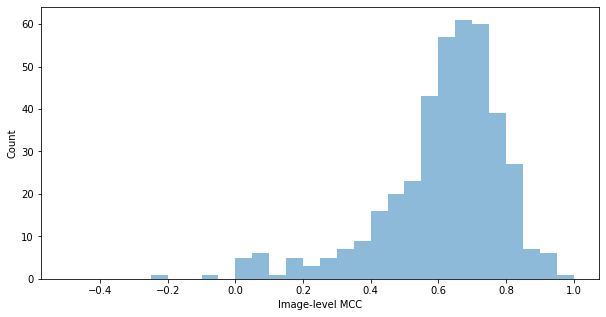

In [153]:
fig, ax = plt.subplots(figsize=(10,5))

bins = np.linspace(-0.5, 1, 31)
plt.hist(mccs, bins=bins, alpha=0.5)
plt.xlabel('Image-level MCC')
plt.ylabel('Count')
plt.show()

In [8]:
splits_df = pd.read_csv('../data/splits/hanAndBurak_planetImagery_splits.csv')
val_df = splits_df[splits_df['fold'] == 'val']
train_df = splits_df[splits_df['fold'] == 'train']
val_df['MCC'] = mccs
train_df['MCC'] = mccs2

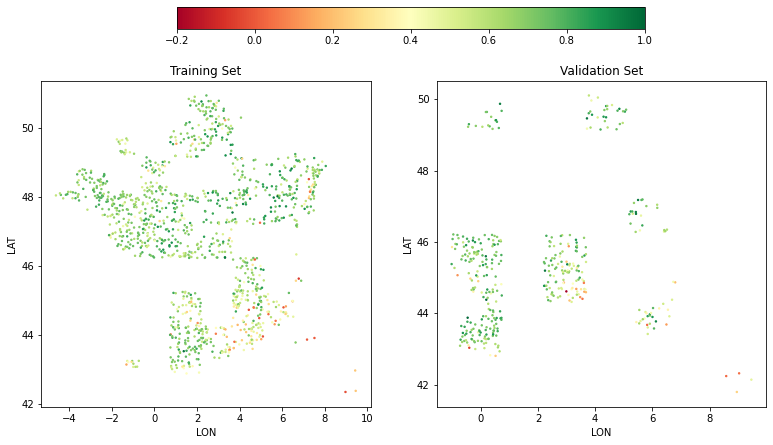

In [185]:
splits_df = pd.read_csv('../data/splits/hanAndBurak_planetImagery_splits.csv')
val_df = splits_df[splits_df['fold'] == 'val']
train_df = splits_df[splits_df['fold'] == 'train']
val_df['MCC'] = mccs
train_df['MCC'] = mccs2

fig, ax = plt.subplots(1,2, figsize=(13,6))
im = ax[0].scatter(train_df['lon'], train_df['lat'], c=train_df['MCC'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df['lon'], val_df['lat'], c=val_df['MCC'], s=2, cmap='RdYlGn')

for i in range(2):
    ax[i].set_xlabel('LON')
    ax[i].set_ylabel('LAT')
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')

cax = fig.add_axes([0.27, 1, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

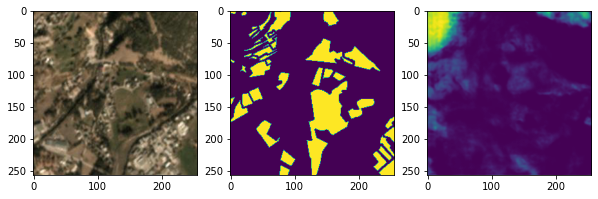

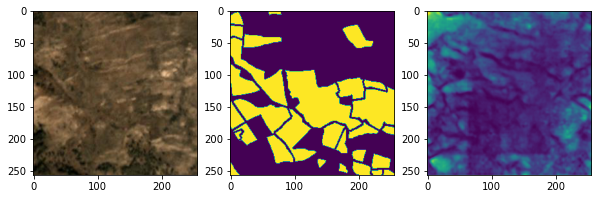

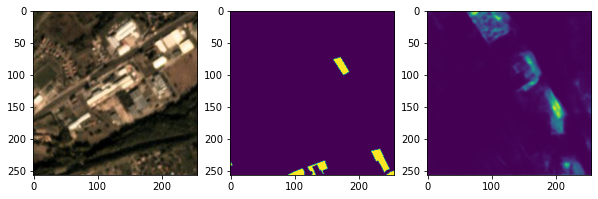

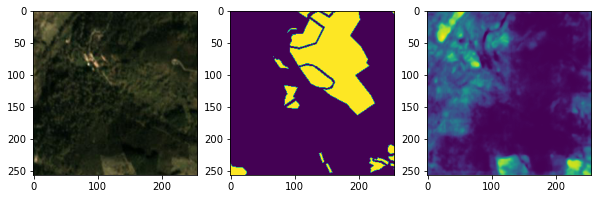

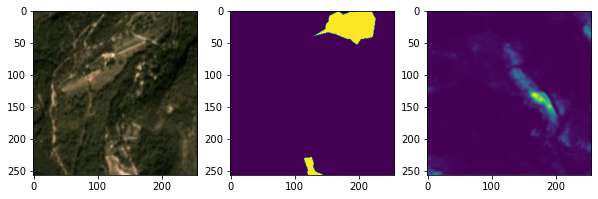

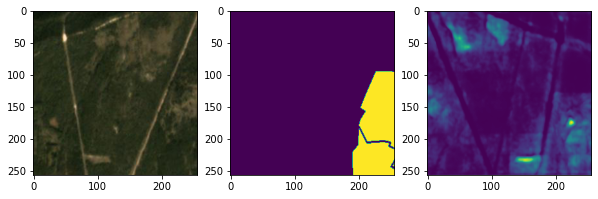

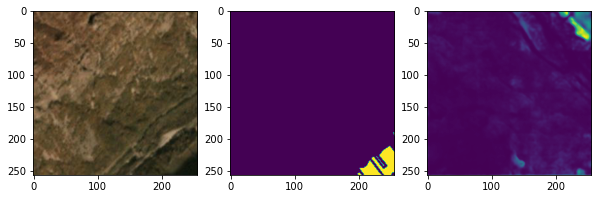

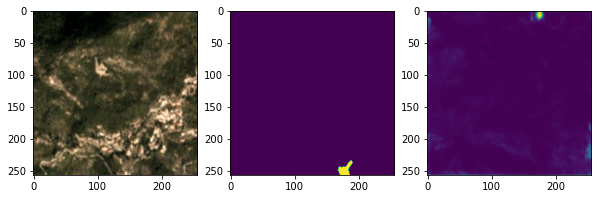

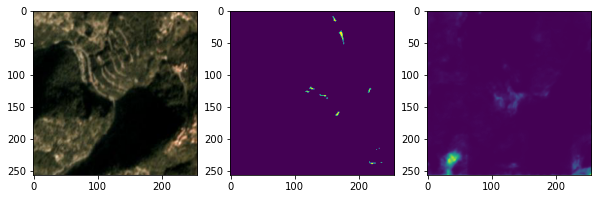

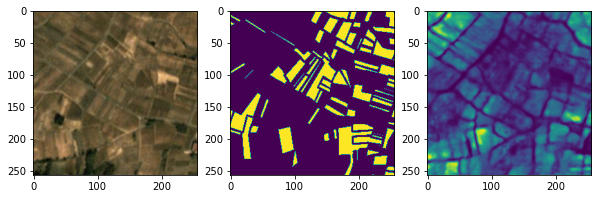

In [205]:
counter = 0
for i, row in train_df.sort_values('MCC').iterrows():
    
    if counter > 9:
        break
        
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    img = imageio.imread('../data/planet/france/october_256x256/{}.jpeg'.format(row['image_id']))
    extent = imageio.imread('../data/planet/france/labels_256x256/{}.png'.format(row['image_id']))
    prediction = np.load('../results/france/hanAndBurak/{}.npy'.format(row['image_id']))
    
    ax[0].imshow(img)
    ax[1].imshow(extent)
    ax[2].imshow(prediction)
    plt.show()
    
    counter += 1

## Symmetric difference

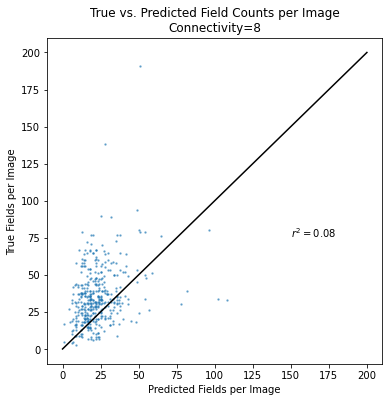

In [75]:
# after taking the symmetric difference
r = pearsonr(true_counts, pred_counts)
r2 = r[0]**2

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(pred_counts, true_counts, s=2, alpha=0.5)
plt.plot([0, 200], [0, 200], '-', color='black')
plt.title('True vs. Predicted Field Counts per Image\nConnectivity=8')
plt.ylabel('True Fields per Image')
plt.xlabel('Predicted Fields per Image')
plt.annotate("$r^2 = ${:0.2f}".format(r2), (150, 75))
plt.show()

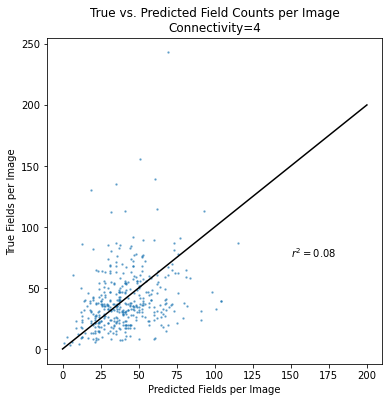

In [78]:
# after taking the symmetric difference
r = pearsonr(true_counts, pred_counts)
r2 = r[0]**2

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(pred_counts, true_counts, s=2, alpha=0.5)
plt.plot([0, 200], [0, 200], '-', color='black')
plt.title('True vs. Predicted Field Counts per Image\nConnectivity=4')
plt.ylabel('True Fields per Image')
plt.xlabel('Predicted Fields per Image')
plt.annotate("$r^2 = ${:0.2f}".format(r2), (150, 75))
plt.show()

## Forests are marked as parcels?

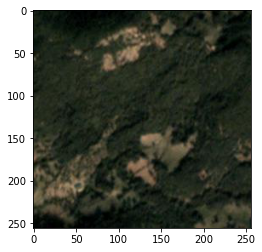

In [73]:
plt.imshow(imageio.imread('../data/planet/france/october_256x256/10004067.jpeg'))
plt.show()

# Try polygon simplification algorithm

Ramer-Douglas-Peucker algorithm: https://rdp.readthedocs.io/en/latest/

Seems unlikely to help much since it will only shrink convex shapes?

In [6]:
from rdp import rdp
import rasterio
import rasterio.features
from shapely.geometry import shape
import matplotlib.patches as patches

## Toy example

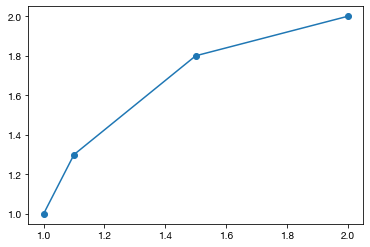

In [10]:
array = np.array([[1,1], [1.1,1.3], [1.5,1.8], [2,2]])
plt.plot(array[:,0], array[:,1], 'o-')
plt.show()

In [12]:
rdp(array, epsilon=0.1)

array([[1. , 1. ],
       [1.5, 1.8],
       [2. , 2. ]])

## Predicted fields

In [227]:
image_id = np.random.choice(os.listdir('../data/planet/france/october_256x256/'))
print(image_id)
image_id = image_id.split('.')[0]
predicted = np.load('../results/france/hanAndBurak/{}.npy'.format(image_id))
thresholded = np.array(predicted > 0.5, dtype=np.uint8)
shapes = rasterio.features.shapes(thresholded)
shapely_shapes = []
for shp, val in shapes:
    if val == 1:
        shapely_shapes.append(shape(shp))

8400349.jpeg


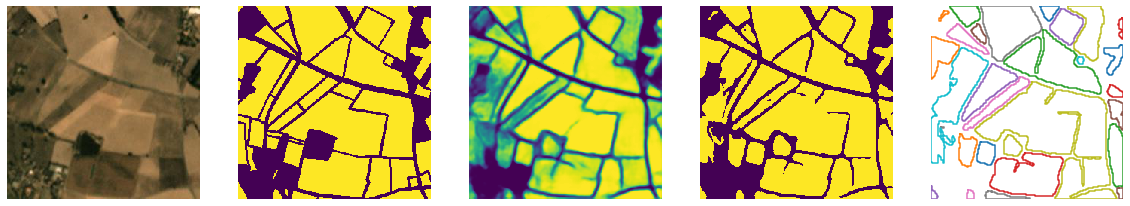

In [228]:
ncols = 5
fig, ax = plt.subplots(1,ncols, figsize=(20,4))
img = imageio.imread('../data/planet/france/october_256x256/{}.jpeg'.format(image_id))
extent = imageio.imread('../data/planet/france/labels_256x256/{}.png'.format(image_id))

ax[0].imshow(img)
ax[1].imshow(extent)
ax[2].imshow(predicted)
ax[3].imshow(thresholded)

for polygon1 in shapely_shapes:
    ax[4].plot(*polygon1.exterior.xy)
ax[4].set_ylim([256, 0])
ax[4].set_xlim([0, 256])
ax[4].set_aspect('equal', adjustable='box')

for i in range(ncols):
    ax[i].axis('off')
plt.show()

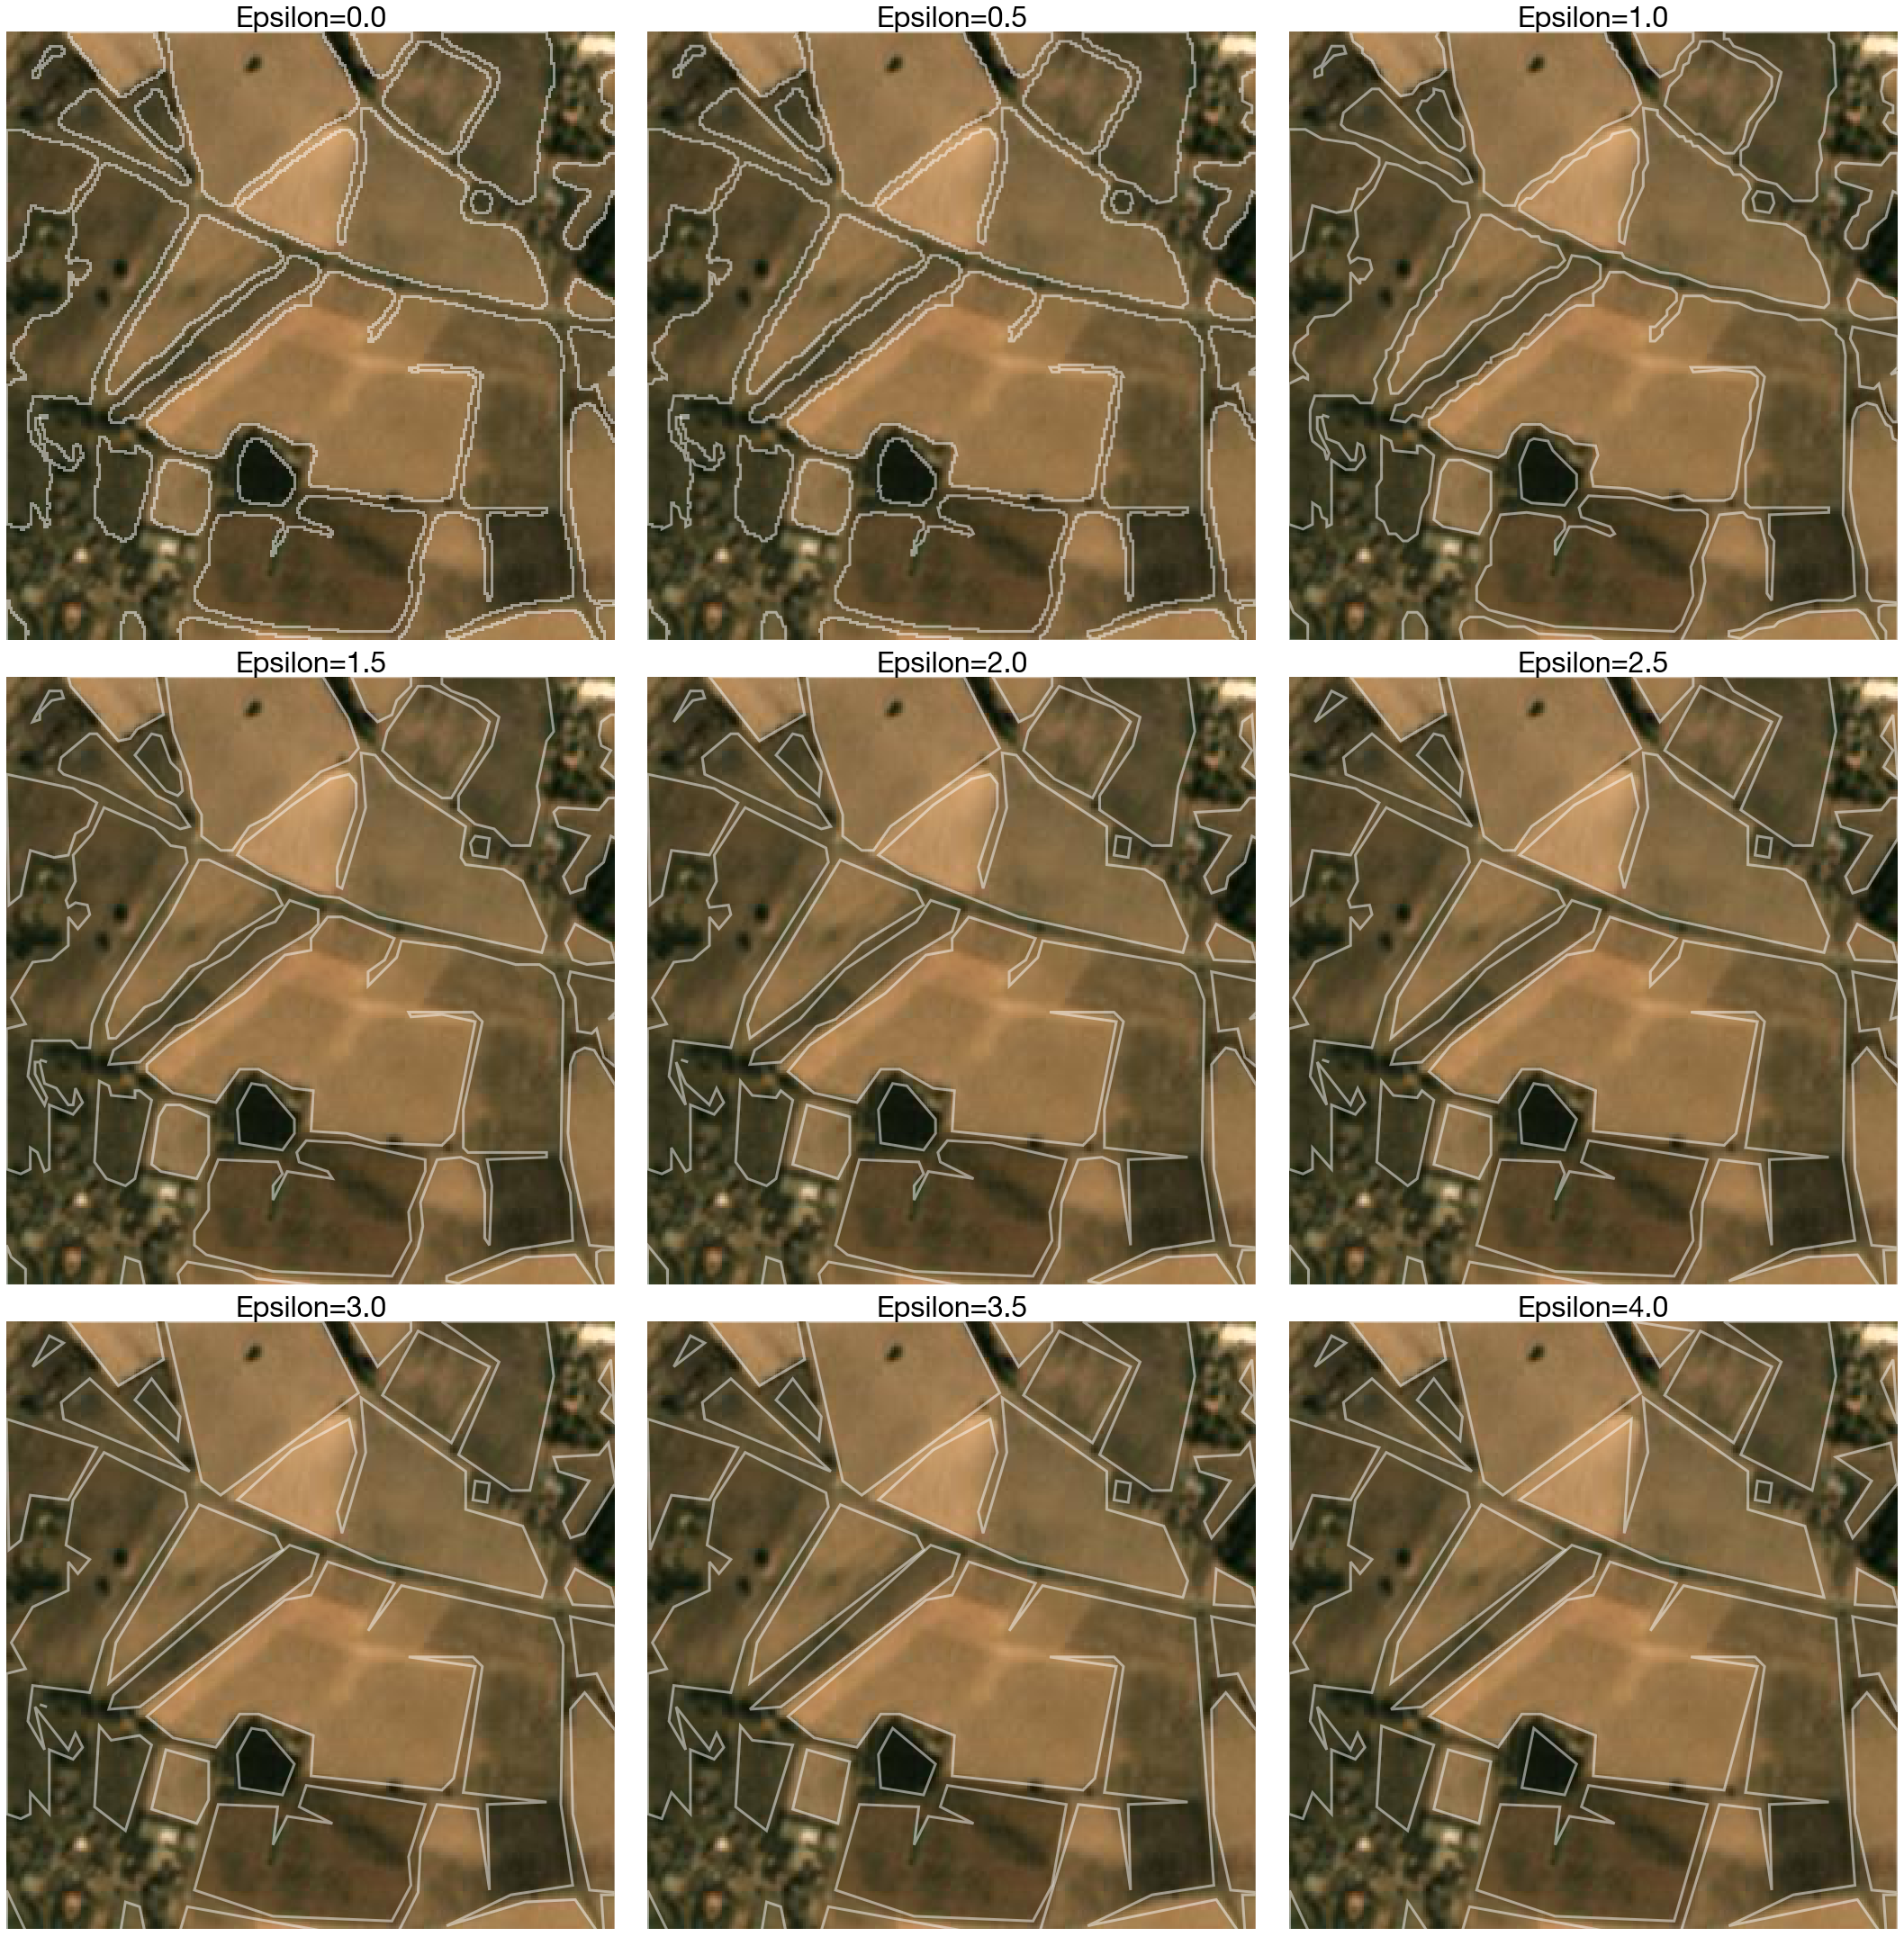

In [229]:
epsilons = np.linspace(0, 4, 9)
nrows = 3
ncols = int(np.ceil(len(epsilons) / nrows))
fig, ax = plt.subplots(nrows, ncols, figsize=(30,30), sharex=True, sharey=True)

for i, eps in enumerate(epsilons):
    r, c = i // ncols, i % ncols
    ax[r,c].imshow(img)
    
    for j, poly in enumerate(shapely_shapes):
        polygon_array = np.array([poly.exterior.xy[0], poly.exterior.xy[1]]).T
        simplified = rdp(polygon_array, epsilon=eps)
        simplified_patch = patches.Polygon(simplified, linewidth=3, edgecolor='white', facecolor='none', alpha=0.5)
        ax[r,c].add_patch(simplified_patch)
#         ax[r,c].plot(simplified[:,0], simplified[:,1])
        
    ax[r,c].set_ylim([256, 0])
    ax[r,c].set_xlim([0, 256])
    ax[r,c].set_aspect('equal')
    ax[r,c].set_title('Epsilon={:0.1f}'.format(eps), fontsize=32)
    ax[r,c].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# creating shapes from vertices
#     new_shapes = []
#         new_shp = {}
#         new_shp['type'] = 'Polygon'
#         new_shp['coordinates'] = [[tuple(x) for x in rdp(polygon_array, epsilon=eps)]]
#         new_shapes.append(shape(new_shp))
#         ax[r,c].plot(*new_shapes[j].exterior.xy)